In [290]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from HeaderP import *
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
   'figure.figsize': [10,10], # instead of 4.5, 4.5
   'savefig.format': 'eps',
   }
plt.rcParams.update(params)

# On Jason's Prot

In [291]:
targets=pd.read_table('Jason2019.csv',delimiter=',')
targets

,Seq,f_,Source,RA_ICRS,DE_ICRS,GBP-GRP,Teff,Gmag,GMag,Prot,Note,Simbad
0,1,NaN,3.200000e+18,04 22 31.5,-07 33 03.2,0.432,7187,8.903,2.802,0.52,Warm,Gaia DR2 3198972700981234048
1,2,NaN,5.180000e+18,03 10 47.3,-06 34 29.8,0.446,7161,8.562,2.954,0.87,Warm,Gaia DR2 5181474045115843072
2,3,NaN,2.520000e+18,02 20 22.6,+05 52 59.1,0.597,6622,9.183,3.534,0.82,Warm,Gaia DR2 2516948215250061568
3,4,NaN,3.250000e+18,04 02 15.4,-05 53 48.2,0.604,6573,9.425,3.513,0.56,Conv.,Gaia DR2 3245408684793798528
4,5,NaN,6.630000e+18,22 36 31.1,-21 35 06.0,0.647,6320,8.967,3.835,0.94,Conv.,Gaia DR2 6628071944405827712
...,...,...,...,...,...,...,...,...,...,...,...,...
96,97,NaN,5.110000e+18,03 51 15.9,-12 23 46.4,1.732,4298,13.375,7.484,0.68,LM,Gaia DR2 5114516020369038848
97,98,NaN,5.070000e+18,02 26 04.6,-29 23 48.9,1.768,4163,12.815,8.000,7.80,LM,Gaia DR2 5068272932125221504
98,99,NaN,5.090000e+18,04 02 18.0,-18 42 45.4,1.771,4076,12.631,7.134,2.62,LM,Gaia DR2 5094664333632217088
99,100,NaN,5.120000e+18,01 57 17.2,-25 13 49.6,1.784,3956,12.793,7.931,5.45,LM,Gaia DR2 5121805541941481472


In [292]:
from lightkurve import search_targetpixelfile
radec=[]
RA=targets['RA_ICRS'].values
DEC=targets['DE_ICRS'].values
GaiaID=targets['Simbad']
Prot_true=targets['Prot']

RAst=[]
DECst=[]
Prot=[]
for i in range(len(RA)):
    RAst.append("+"+str(RA[i]).replace(" ", ":"))
    DECst.append(str(DEC[i]).replace(" ", ":"))
    Prot.append(Prot_true[i])
    radec.append(str(RA[i]).replace(" ", ":")+" "+str(DEC[i]).replace(" ", ":"))

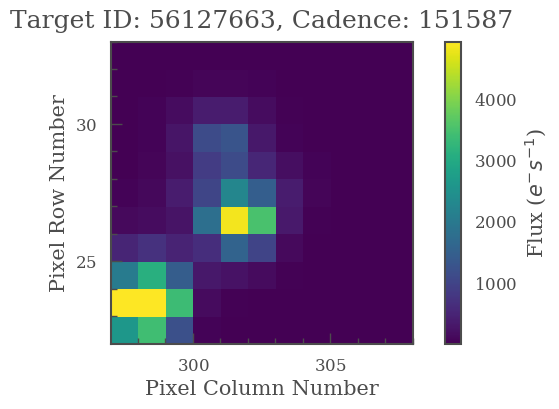

In [308]:
pixelfile = search_targetpixelfile(radec[7]).download(quality_bitmask='hardest');
pixelfile.plot(frame=1)
lc = pixelfile.to_lightcurve(aperture_mask='all');

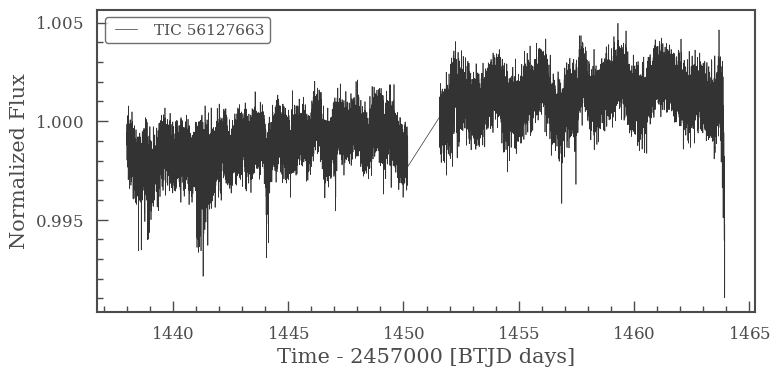

In [309]:
lc.plot()
dt=pd.DataFrame(np.array((lc.time,lc.flux)).T,columns=['time','flux'])
dt.to_csv('Star6.csv',index=False)

In [256]:
result = search_targetpixelfile(radec[0])

In [262]:
pixelfile.header[22]

37860207

In [313]:
from astropy.timeseries import LombScargle
def getRvar(Flux):
    return abs(np.percentile(Flux,95)-np.percentile(Flux,5))

def getPspec(t,sig,sig_err):
    # lomb-scargle
    #### define frequency use to analyze
    frequency, power = LombScargle(t* u.day,sig,sig_err).autopower()

    return 1/frequency[np.argmax(power)],max(power)   

Rvar=np.zeros(len(targets))
TIC=np.zeros(len(targets))
LG_peak=np.zeros(len(targets))
for i in range(len(radec)):
    update_progress(i/len(radec))
    pixelfile = search_targetpixelfile(radec[i]).download(quality_bitmask='hardest')
    try:
        TIC[i]=pixelfile.header[22]
        lc = pixelfile.to_lightcurve(aperture_mask='all');
        Rvar[i]=getRvar(lc.flux/np.median(lc.flux))
        LG_Prot,LG_peak[i]=getPspec(lc.time,lc.flux/np.median(lc.flux),lc.flux_err/np.median(lc.flux))
    except:
        TIC[i]=0
        Rvar[i]=0
        LG_peak[i]=0
    print(Rvar[i],TIC[i],LG_peak[i])


Progress: [####################] 99.0%
0.0 0.0 0.0


/Users/lucy/anaconda3/lib/python3.7/site-packages/lightkurve/search.py:177: LightkurveWarning: Cannot download from an empty search result.
  LightkurveWarning)


# save into csv 

In [317]:
TICdf=pd.DataFrame(np.array((TIC,[float(i)*1e6 for i in Rvar],RAst,DECst,Prot,LG_peak)).T,columns=['TIC','Rvar','RA','DEC','Prot','LG_peaks'])
TICdf['TIC']=TICdf['TIC'].replace([str(0.0)], np.nan)
TICdf=TICdf.dropna(subset=['TIC'])
TICdf.to_csv('TICs.csv',index=False)
TICdf

,TIC,Rvar,RA,DEC,Prot,LG_peaks
0,37860207.0,6780.165433883712,+04:22:31.5,-07:33:03.2,0.52,0.5153271270372446
1,9805084.0,15338.242053985596,+03:10:47.3,-06:34:29.8,0.87,0.4629457061673874
2,420000810.0,10116.332769393943,+02:20:22.6,+05:52:59.1,0.82,1.1133912532701447
3,9148352.0,3939.4974708559794,+04:02:15.4,-05:53:48.2,0.56,0.13111132249983876
4,399570739.0,12135.49375534062,+22:36:31.1,-21:35:06.0,0.94,0.5775338814041966
6,257434109.0,12086.960673332036,+01:32:34.4,-12:51:09.7,1.24,0.7160941037868864
7,56127663.0,5104.83980178833,+04:43:02.6,-07:53:54.5,1.71,0.6348789950740624
8,152439649.0,13239.610195159734,+05:02:35.2,-12:31:20.4,0.91,0.674585771257517
9,169396430.0,12450.349330902056,+05:07:09.2,-13:34:07.7,0.97,0.2133439717892359
10,248655215.0,8257.93147087095,+04:29:21.6,-02:49:47.1,1.97,0.5333558276932323


In [321]:
Gaia=pd.read_table('Gaia_Jason2019.csv',delimiter=',')
Gaia.rename(columns={'RA':'ra'}, inplace=True)
Gaia.rename(columns={'DEC':'dec'}, inplace=True)
TICdf['TIC']=[float(i) for i in TICdf['TIC']]
v_tan,v_b=CalcV(Gaia)
Gaia['v_tan']=v_tan
Gaia['v_b']=v_b

print(np.shape(targets))
print(np.shape(Gaia))

GaiaCM=pd.merge(TICdf,Gaia,left_on='TIC',right_on='TIC',how='inner')
GaiaCM.to_pickle("TESStest1")
GaiaCM

(101, 12)
(39, 98)


,TIC,Rvar,RA,DEC,Prot,LG_peaks,ra,dec,MatchID,MatchRA,...,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,v_tan,v_b
0,37860207.0,6780.165433883712,+04:22:31.5,-07:33:03.2,0.52,0.5153271270372446,65.631250,-7.550889,3.198970e+18,65.631284,...,0.2638,200111.0,1.521236,1.466736,1.673330,5.564717,5.502510,5.626925,9.857061,-9.748409
1,9805084.0,15338.242053985596,+03:10:47.3,-06:34:29.8,0.87,0.4629457061673874,47.697083,-6.574944,5.181470e+18,47.697096,...,0.2120,200111.0,1.428846,1.342728,1.493637,4.836925,4.756934,4.916915,3.914573,-2.484842
2,420000810.0,10116.332769393943,+02:20:22.6,+05:52:59.1,0.82,1.1133912532701447,35.094167,5.883083,2.516950e+18,35.094028,...,0.1151,200111.0,1.274123,1.182974,1.329577,2.813536,2.791792,2.835280,11.174658,-7.933313
3,9148352.0,3939.4974708559794,+04:02:15.4,-05:53:48.2,0.56,0.13111132249983876,60.564167,-5.896722,3.245410e+18,60.564186,...,0.1331,200111.0,1.305733,1.244879,1.359100,2.867810,2.841571,2.894048,6.500931,-6.372148
4,399570739.0,12135.49375534062,+22:36:31.1,-21:35:06.0,0.94,0.5775338814041966,339.129583,-21.585000,6.628070e+18,339.129743,...,0.1281,200111.0,1.219056,1.184879,1.258435,2.136046,2.122790,2.149302,15.967017,-15.800319
5,257434109.0,12086.960673332036,+01:32:34.4,-12:51:09.7,1.24,0.7160941037868864,23.143333,-12.852694,2.456990e+18,23.143394,...,0.1440,200111.0,1.226248,1.148886,1.298588,2.079945,2.067743,2.092147,6.611179,1.668069
6,56127663.0,5104.83980178833,+04:43:02.6,-07:53:54.5,1.71,0.6348789950740624,70.760833,-7.898472,3.186200e+18,70.760804,...,0.0821,200111.0,1.306515,1.248328,1.336886,2.281532,2.254307,2.308758,9.265267,-9.262003
7,152439649.0,13239.610195159734,+05:02:35.2,-12:31:20.4,0.91,0.674585771257517,75.646667,-12.522333,2.988100e+18,75.646847,...,0.1508,200111.0,1.174436,1.103101,1.285468,2.068497,2.048055,2.088939,9.693961,-9.691538
8,169396430.0,12450.349330902056,+05:07:09.2,-13:34:07.7,0.97,0.2133439717892359,76.788333,-13.568806,2.987730e+18,76.788243,...,0.1499,200111.0,1.216684,1.093531,1.315485,2.022425,2.005284,2.039567,10.768716,-10.605002
9,248655215.0,8257.93147087095,+04:29:21.6,-02:49:47.1,1.97,0.5333558276932323,67.340000,-2.829750,3.204840e+18,67.340092,...,0.1290,200111.0,1.175051,1.124403,1.195347,1.806430,1.787915,1.824945,12.268997,-12.060972


# Run through classifier

In [336]:
Features_c=['LG_peaks', 'Rvar', 'parallax', 'radius_percentile_lower', 'radius_percentile_upper', 'phot_g_mean_flux_over_error', 'bp_g'] # for classifer
Features=['Rvar', 'teff_val', 'bp_g', 'lum_val', 'v_tan', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b'] # for regression

GaiaCM=GaiaCM.dropna(subset=Features_c)
GaiaCM=GaiaCM.dropna(subset=Features)
GaiaCM=GaiaCM.dropna(subset=['Prot'])

print(np.shape(GaiaCM))
testSet_c=GaiaCM[Features_c]

for i in Features_c:
    testSet_c[i]=[float(j) for j in testSet_c[i]]
    

(38, 104)


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [357]:
from sklearn.externals import joblib
regr_c = joblib.load('RF_Class_model.sav')
regr_100 = joblib.load('RF_Regre_model.sav')
regr = joblib.load('RF_Regre_model_3est.sav')
regr_2 = joblib.load('RF_Regre_model_2est.sav')
regr_1 = joblib.load('RF_Regre_model_1est.sav')

# classify first...
probs = regr_c.predict_proba(testSet_c)
preds = probs[:,1]
for i in range(len(preds)):
    if preds[i]<=0.4:
        preds[i]=0
    else:
        preds[i]=1

GaiaCM['Prot_c']=preds

# get ones that can get period
GaiaCM_pred=GaiaCM.loc[GaiaCM['Prot_c']==1]
print("Total stars:",len(GaiaCM))
print("Stars that can get Prot:",len(GaiaCM_pred))

testSet=GaiaCM_pred[Features]
for i in Features:
    testSet[i]=[float(j) for j in testSet[i]]
    
Prot_test=[float(i) for i in GaiaCM_pred['Prot']]
testSet

Total stars: 38
Stars that can get Prot: 38


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Rvar,teff_val,bp_g,lum_val,v_tan,phot_g_mean_flux_over_error,v_b,radius_val,b
0,6780.165434,7187.680,0.172399,5.564717,9.857061,3435.9480,-9.748409,1.521236,-36.418957
1,15338.242054,7161.037,0.178966,4.836925,3.914573,1091.3950,-2.484842,1.428846,-51.067453
2,10116.332769,6622.680,0.241447,2.813536,11.174658,2891.1940,-7.933313,1.274123,-50.600063
3,3939.497471,6573.350,0.241963,2.867810,6.500931,4847.8910,-6.372148,1.305733,-39.985651
4,12135.493755,6320.000,0.270962,2.136046,15.967017,1136.6360,-15.800319,1.219056,-58.871986
5,12086.960673,6259.650,0.268032,2.079945,6.611179,2965.4480,1.668069,1.226248,-72.781292
6,5104.839802,6206.200,0.265914,2.281532,9.265267,2228.6780,-9.262003,1.306515,-32.079468
7,13239.610195,6387.420,0.267090,2.068497,9.693961,1752.2570,-9.691538,1.174436,-29.747006
8,12450.349331,6240.300,0.270852,2.022425,10.768716,1562.9890,-10.605002,1.216684,-29.156832
9,8257.931471,6173.100,0.278132,1.806430,12.268997,2100.4140,-12.060972,1.175051,-32.611822


Text(0.5, 0, 'True Rotation [days]')

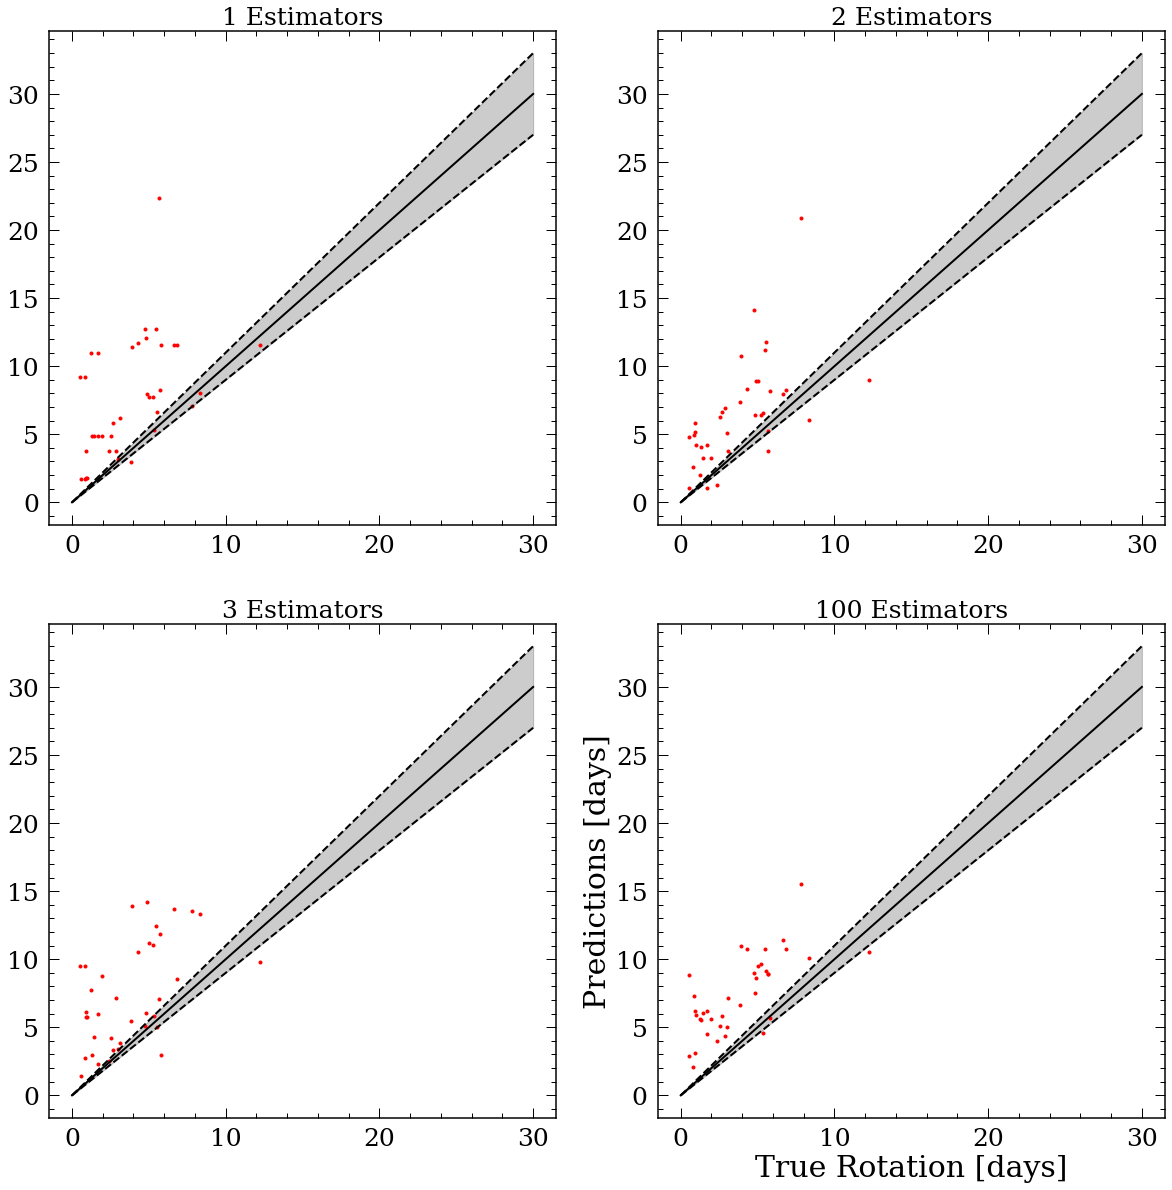

In [361]:
predictp=regr.predict(testSet) # 3 estimators
predictp_1=regr_1.predict(testSet) # 1 estimators
predictp_2=regr_2.predict(testSet) # 2 estimators
predictp_100=regr_100.predict(testSet) # 100 estimators

lims=30

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title('1 Estimators',fontsize=25)
plt.plot(Prot_test,predictp_1,'r.',label='2 estimators')
plt.plot([0,lims],[0,lims],'k-',label='y=x')
plt.plot([0,lims],[0,0.9*lims],'k--')
plt.plot([0,lims],[0,1.1*lims],'k--',label='10% error')
plt.fill_between([0,lims], [0,0.9*lims], [0,1.1*lims], color='black', alpha='0.2')
plt.subplot(2,2,2)
plt.title('2 Estimators',fontsize=25)
plt.plot(Prot_test,predictp_2,'r.',label='2 estimators')
plt.plot([0,lims],[0,lims],'k-',label='y=x')
plt.plot([0,lims],[0,0.9*lims],'k--')
plt.plot([0,lims],[0,1.1*lims],'k--',label='10% error')
plt.fill_between([0,lims], [0,0.9*lims], [0,1.1*lims], color='black', alpha='0.2')
plt.subplot(2,2,3)
plt.title('3 Estimators',fontsize=25)
plt.plot(Prot_test,predictp,'r.',label='3 estimators')
plt.plot([0,lims],[0,lims],'k-',label='y=x')
plt.plot([0,lims],[0,0.9*lims],'k--')
plt.plot([0,lims],[0,1.1*lims],'k--',label='10% error')
plt.fill_between([0,lims], [0,0.9*lims], [0,1.1*lims], color='black', alpha='0.2')
plt.subplot(2,2,4)
plt.title('100 Estimators',fontsize=25)
plt.plot(Prot_test,predictp_100,'r.',label='100 estimators')
plt.plot([0,lims],[0,lims],'k-',label='y=x')
plt.plot([0,lims],[0,0.9*lims],'k--')
plt.plot([0,lims],[0,1.1*lims],'k--',label='10% error')
plt.fill_between([0,lims], [0,0.9*lims], [0,1.1*lims], color='black', alpha='0.2')


#plt.ylim([0,max(Prot_test)])
#plt.xlim([0,max(Prot_test)])
plt.ylabel('Predictions [days]')
plt.xlabel('True Rotation [days]')


Text(0, 0.5, 'Rvar')

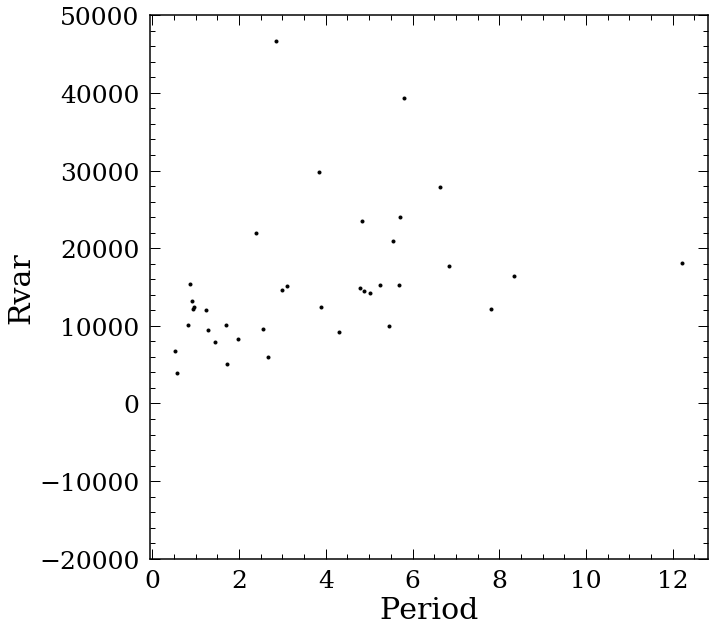

In [344]:
plt.figure()
plt.plot(Prot_test,testSet['Rvar'],'k.')
plt.ylim([-20000,50000])
plt.xlabel('Period')
plt.ylabel('Rvar')

# Use Kepler TESS lcs

In [ ]:
regr = joblib.load('RF_Regre_model.sav')